In [1]:
import torch 
import torch.nn as nn
import torch.nn.init as init
from copy import deepcopy
# global seed
seed = 42
torch.manual_seed(seed)


import matplotlib.pyplot as plt

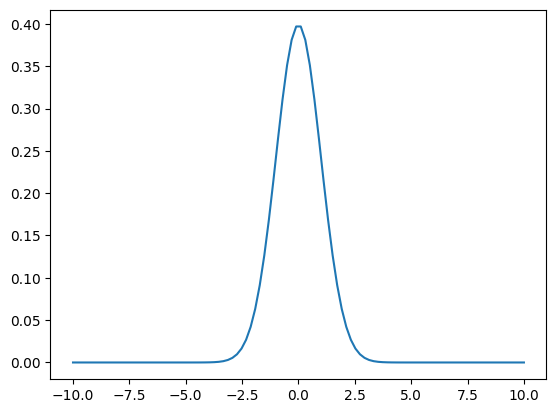

In [2]:
rand_coefs1 = torch.randn(10)
def f1(x):
    res = 0
    for i in range(len(rand_coefs1)):
        res += rand_coefs1[i] * (x ** i)
    return res

def f2(x):
    res = 0
    for i in range(4):
        res += rand_coefs1[i] * (x ** i)
    return res

def objective_generator(num_funcs):
    funcs = []
    for i in range(num_funcs):
        def f(x):
            return (1/torch.sqrt(torch.tensor(2*torch.pi))) * torch.exp(-0.5 * x ** 2)
            rand_coefs = torch.randn(11)       
            res = 0
            for i in range(len(rand_coefs)):
                res += rand_coefs[i] * (x ** i)
            return res
        funcs.append(f)
    return funcs

test_range = torch.linspace(-10, 10, 100)
funcs = objective_generator(1)
for f in funcs:
    plt.plot(test_range, f(test_range), label='f')


In [3]:
def xavier_init_sequential(model):
    """
    Apply Xavier initialization to the weights of all applicable layers
    in a torch.nn.Sequential model.

    Args:
        model (torch.nn.Sequential): The model to initialize.
    """
    for layer in model:
        if isinstance(layer, nn.Linear):  # Check if the layer has weights to initialize
            init.xavier_uniform_(layer.weight)  # Apply Xavier uniform initialization
            if layer.bias is not None:  # Initialize bias to zero
                init.zeros_(layer.bias)

In [4]:
def create_nets(num: int=5):
    net = nn.Sequential(
        nn.Linear(1, 100),
        nn.ReLU(),
        nn.Linear(100, 1)
    )

    xavier_init_sequential(net)

    nets = [deepcopy(net) for _ in range(num)]
    num_params = sum(p.numel() for p in nets[0].parameters())

    # meta_optimizer = nn.Sequential(
    #     nn.Linear(num_params*2, num_params*20),
    #     nn.ReLU(),
    #     nn.Linear(num_params*20, num_params),
    #     nn.ReLU(),
    #     nn.Linear(num_params, num_params)
    # )
    # xavier_init_sequential(meta_optimizer)
    return nets


In [5]:
# random floats between -10, 10
X = torch.rand(10000, 1) * 6 - 3

num_tasks = 1
funcs = objective_generator(num_tasks)
labels = [f(X) for f in funcs]
# rescale each labels to -1, 1
labels = [(l - l.min()) / (l.max() - l.min()) * 2 - 1 for l in labels]
labels = torch.stack(labels, dim=1)
print(labels[:3,:2])
X.shape, labels.shape

tensor([[[-0.2444]],

        [[ 0.8786]],

        [[-0.0598]]])


(torch.Size([10000, 1]), torch.Size([10000, 1, 1]))

In [107]:
losses= {i: [] for i in range(num_tasks)}
batch_size = 32

nets = create_nets(num_tasks)
for net_id, net in enumerate(nets):
    for epoch in range(150):
        for batch_idx in range(0, len(X), batch_size):
            X_batch = X[batch_idx:batch_idx+batch_size]
            y = labels[:, net_id]
            y_batch = y[batch_idx:batch_idx+batch_size]
            net.train()
            y_pred = net(X_batch)
                    
            loss = ((y_pred - y_batch)**2).sum()
            losses[net_id].append(loss.item())
            loss.backward()

            # params = torch.cat([p.detach().view(-1) for p in net.parameters()])
            # grads = torch.cat([p.grad.detach().view(-1) for p in net.parameters()])
            # grads[torch.isnan(grads)] = 0

            # # concat params and grads
            # params_grads = torch.cat([params, grads])


            with torch.no_grad():
                for p in net.parameters():
                    p -= 1e-3 * p.grad
                    p.grad.zero_()
            # updated_params = torch.cat([p.view(-1).detach() for p in net.parameters()])
            # net.eval()
            # predicted_params = meta_optimizer(params_grads)



            # meta_loss = ((updated_params - predicted_params)**2).sum()
            # meta_loss.backward()
            # with torch.no_grad():
            #     for p in net.parameters():
            #         p -= 1e-3 * p.grad
            #         p.grad.zero_()
            meta_loss = torch.tensor(0) 

            if batch_idx%500 ==0:
                print(f"Net {net_id}, Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}, Meta Loss {meta_loss.item()}")
            


Net 0, Epoch 0, Batch 0, Loss 14.179883003234863, Meta Loss 0
Net 0, Epoch 0, Batch 4000, Loss 0.6515415906906128, Meta Loss 0
Net 0, Epoch 0, Batch 8000, Loss 0.595999002456665, Meta Loss 0
Net 0, Epoch 1, Batch 0, Loss 0.6736963391304016, Meta Loss 0
Net 0, Epoch 1, Batch 4000, Loss 0.5107905268669128, Meta Loss 0
Net 0, Epoch 1, Batch 8000, Loss 0.5479195713996887, Meta Loss 0
Net 0, Epoch 2, Batch 0, Loss 0.6282213926315308, Meta Loss 0
Net 0, Epoch 2, Batch 4000, Loss 0.4693813920021057, Meta Loss 0
Net 0, Epoch 2, Batch 8000, Loss 0.5115319490432739, Meta Loss 0
Net 0, Epoch 3, Batch 0, Loss 0.5903276205062866, Meta Loss 0
Net 0, Epoch 3, Batch 4000, Loss 0.43116024136543274, Meta Loss 0
Net 0, Epoch 3, Batch 8000, Loss 0.4755789339542389, Meta Loss 0
Net 0, Epoch 4, Batch 0, Loss 0.5483707189559937, Meta Loss 0
Net 0, Epoch 4, Batch 4000, Loss 0.390521377325058, Meta Loss 0
Net 0, Epoch 4, Batch 8000, Loss 0.4351983666419983, Meta Loss 0
Net 0, Epoch 5, Batch 0, Loss 0.502909064

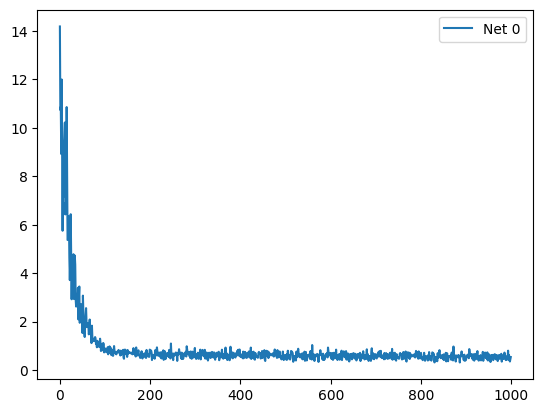

In [108]:
# plot losses
cutoff = 1000
for i in range(num_tasks):
    plt.plot(losses[i][:cutoff], label=f'Net {i}')
plt.legend()
plt.show()

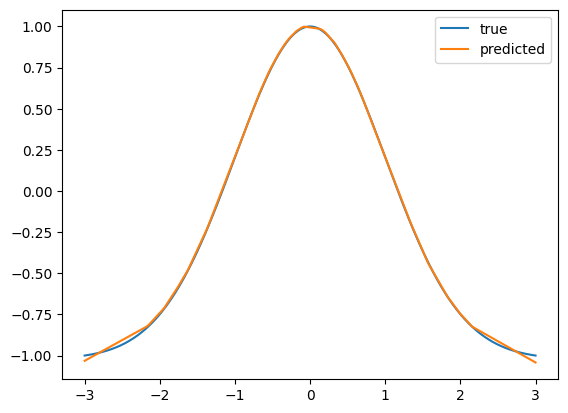

In [109]:
for i,net in enumerate(nets[:10]):
    net.eval()
    X_test = torch.linspace(-3, 3, 1000).reshape(-1, 1)
    y_pred = net(X_test)
    y_test = funcs[i](X_test)
    # rescale y_test
    y_test = (y_test - y_test.min()) / (y_test.max() - y_test.min()) * 2 - 1

    plt.plot(X_test, y_test, label='true')
    plt.plot(X_test, y_pred.detach(), label='predicted')
    plt.legend()
    plt.show()

In [11]:
import plotly.graph_objects as go

In [36]:
# visualize loss surface for oen net
def func(x):
    return x**2
net = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)
def forward(x):
    return net(x)
def loss(pred, target, reg=0.5):
    return (pred - target).pow(2) + reg * torch.norm(net[0].weight, p=2)

x = torch.linspace(-10, 10, 100)
y = torch.linspace(-10, 10, 100)
dataset = torch.rand(100, 2) * 20 - 10
labels = torch.tensor(func(dataset))
X, Y = torch.meshgrid(x, y)
# Z = torch.zeros_like(X)

# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         # set the weights of the net
#         net[0].weight.data = torch.tensor([[X[i,j], Y[i,j]]])
#         Z[i,j] = torch.mean(loss(forward(dataset), labels, reg=10))


# fig = go.Figure(data=[go.Surface(z=Z.detach().numpy(), x=X.detach().numpy(), y=Y.detach().numpy())], layout=go.Layout(title='Loss Surface'),
# )
# # set size
# fig.update_layout(
#     width=800,
#     height=500,
# )
# fig.show()

# Z = torch.zeros_like(X)
# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         # set the weights of the net
#         net[0].weight.data = torch.tensor([[X[i,j], Y[i,j]]])
#         Z[i,j] = torch.mean(loss(forward(dataset), labels, reg=0))


# fig = go.Figure(data=[go.Surface(z=Z.detach().numpy(), x=X.detach().numpy(), y=Y.detach().numpy())], layout=go.Layout(title='Loss Surface'), 
# )
# fig.update_layout(
#     width=800,
#     height=500,
# )
# fig.show()


regs = [0, 0.1, 0.5, 1, 5, 10]
for reg in regs:
    Z = torch.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # set the weights of the net
            net[0].weight.data = torch.tensor([[X[i,j], Y[i,j]]])
            Z[i,j] = torch.mean(loss(forward(dataset), labels, reg=reg))

    fig = go.Figure(data=[go.Surface(z=Z.detach().numpy(), x=X.detach().numpy(), y=Y.detach().numpy())], layout=go.Layout(title=f'Loss Surface, reg={reg}'), 
    )
    fig.update_layout(
        width=800,
        height=500,
    )
    fig.show()
